Product Category Mapping: {'Bakery': 0, 'Beverages': 1, 'Eggs, Meat & Fish': 2, 'Food Grains': 3, 'Fruits & Veggies': 4, 'Oil & Masala': 5, 'Snacks': 6}
          Model  Silhouette Score  Davies-Bouldin Index
0       K-Means          0.396396              1.267073
1  Hierarchical          0.125526              1.657574
2        DBSCAN         -0.055621              0.751303


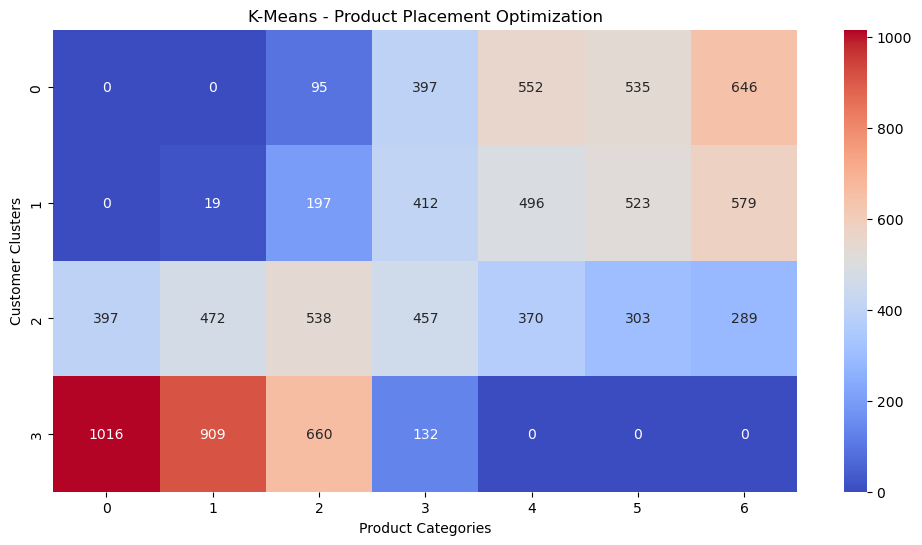

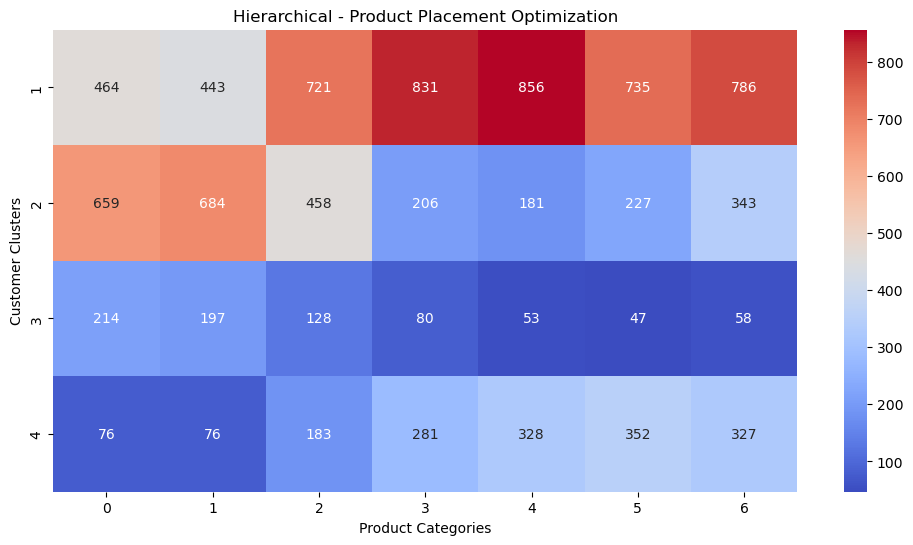

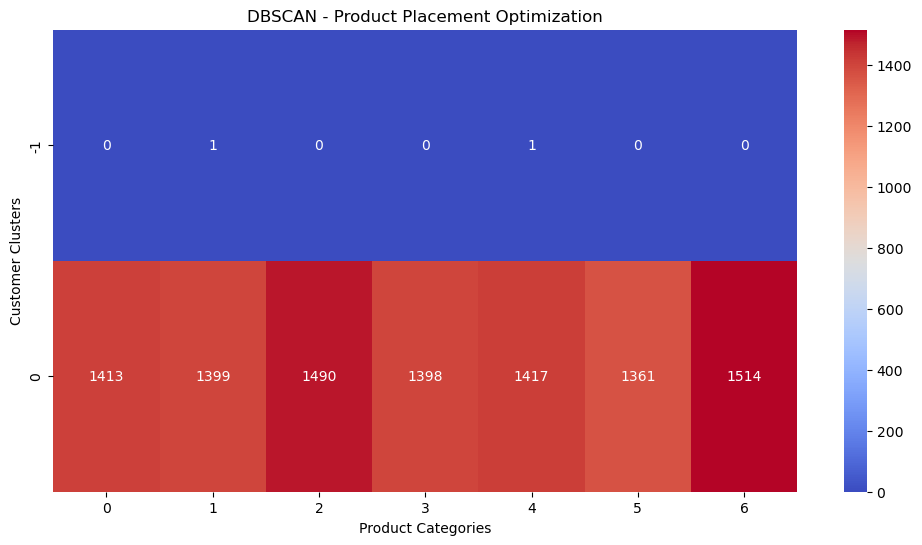

<Figure size 1200x600 with 0 Axes>

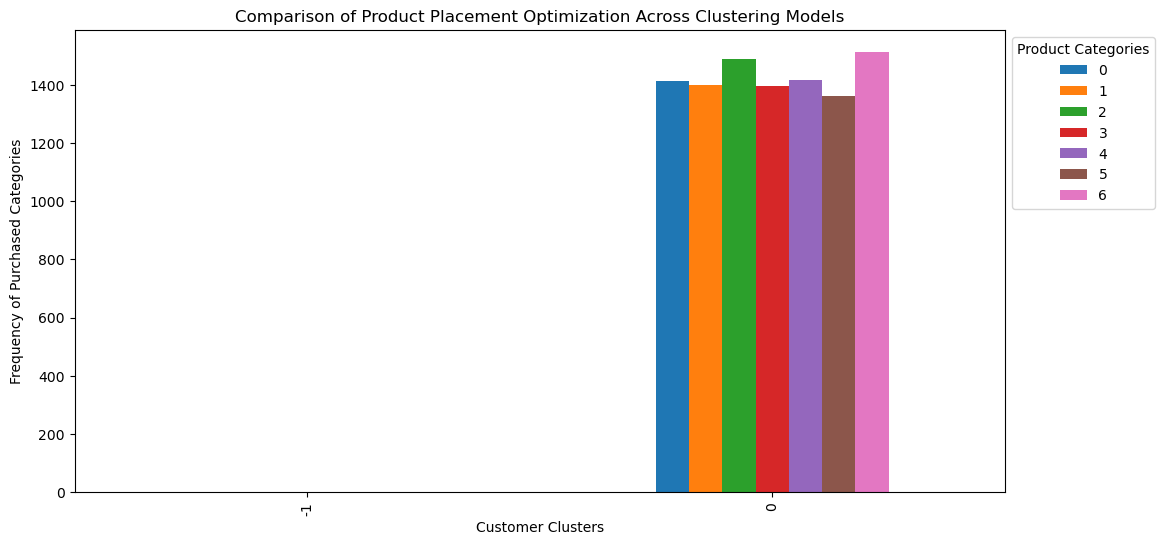

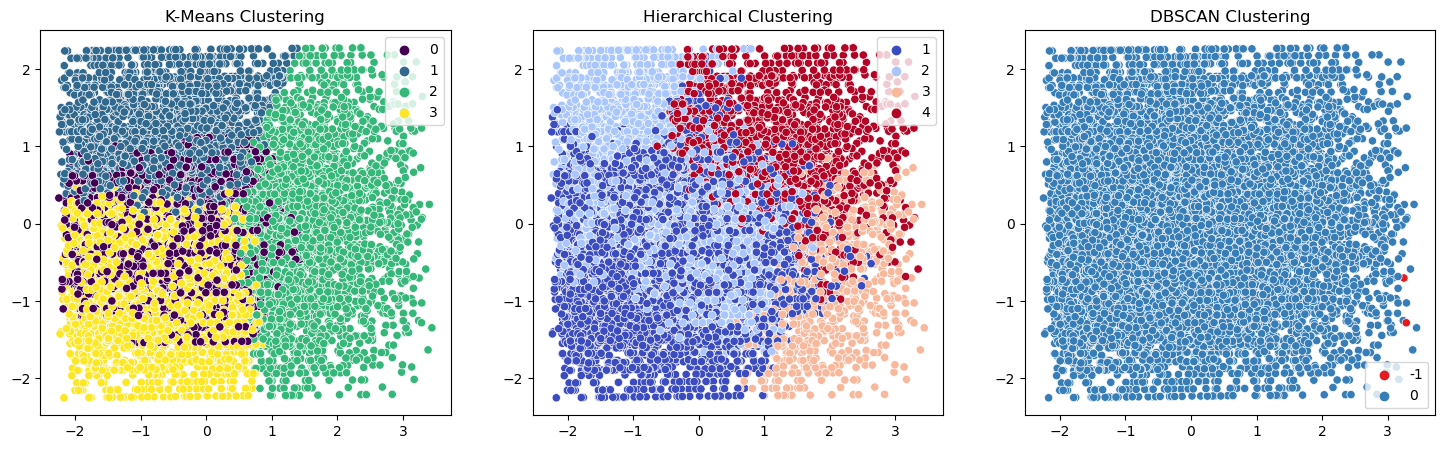

Based on the evaluation metrics, K-Means performed best for this dataset.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import random

# Load dataset
data = pd.read_csv("C:/Users/DELL/Downloads/ML_Proj1/Supermart Grocery Sales - Retail Analytics Dataset.csv")

# Handle missing values
data.fillna(method='ffill', inplace=True)

# Ensure 'Product_Category' column exists
if 'Product_Category' not in data.columns:
    print("Warning: 'Product_Category' column not found in the dataset. Using a default category.")
    data['Product_Category'] = 'Unknown'

# Encode categorical variables
encoder = LabelEncoder()
if 'Product_Category' in data.columns:
    data['Product_Category'] = encoder.fit_transform(data['Product_Category'])
    category_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    print("Product Category Mapping:", category_mapping)

# Drop non-relevant columns
columns_to_drop = ['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender', 'Date', 'Time', 'Payment', 'gross margin percentage', 'gross income']
data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.select_dtypes(include=[np.number]))

# Apply PCA for dimensionality reduction
pca = PCA(n_components=min(10, data_scaled.shape[1]))  # Reduce to 10 dimensions or less
pca_data = pca.fit_transform(data_scaled)

# K-Means Clustering
def kmeans_clustering(data_scaled, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    return kmeans.fit_predict(data_scaled)

kmeans_labels = kmeans_clustering(data_scaled)

# Hierarchical Clustering with Optimization
def hierarchical_clustering(data_scaled, n_clusters=4, sample_size=1000):
    sampled_indices = np.random.choice(data_scaled.shape[0], min(sample_size, data_scaled.shape[0]), replace=False)
    sampled_data = data_scaled[sampled_indices]

    linkage_matrix = linkage(sampled_data, method='average')  # Using 'average' instead of 'ward'
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

    # Assign clusters back to the full dataset using nearest neighbor mapping
    nn = NearestNeighbors(n_neighbors=1).fit(sampled_data)
    _, indices = nn.kneighbors(data_scaled)
    full_labels = [cluster_labels[i] for i in indices.flatten()]
    
    return np.array(full_labels)

hierarchical_labels = hierarchical_clustering(data_scaled)

# DBSCAN Clustering with Subsampling and PCA
def dbscan_clustering(data_scaled, eps=0.5, min_samples=5, sample_size=10000):
    sample_size = min(sample_size, data_scaled.shape[0])  # Ensure sample_size does not exceed dataset size
    sampled_indices = np.random.choice(data_scaled.shape[0], sample_size, replace=False)
    sampled_data = data_scaled[sampled_indices]
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = np.full(data_scaled.shape[0], -1)  # Default all to noise
    labels[sampled_indices] = dbscan.fit_predict(sampled_data)
    return labels

dbscan_labels = dbscan_clustering(pca_data)

# Evaluation Metrics with Subsampling
def evaluate_clustering(data_scaled, labels, sample_size=5000):
    sample_size = min(sample_size, data_scaled.shape[0])  # Ensure sample_size does not exceed dataset size
    sampled_indices = np.random.choice(data_scaled.shape[0], sample_size, replace=False)
    data_sampled = data_scaled[sampled_indices]
    labels_sampled = np.array(labels)[sampled_indices]
    
    unique_labels = set(labels_sampled)
    if len(unique_labels) > 1:
        silhouette = silhouette_score(data_sampled, labels_sampled, metric='cosine')
        db_index = davies_bouldin_score(data_sampled, labels_sampled)
    else:
        silhouette = -1
        db_index = float('inf')
    
    return silhouette, db_index

# Evaluate each model
kmeans_silhouette, kmeans_db = evaluate_clustering(pca_data, kmeans_labels)
hierarchical_silhouette, hierarchical_db = evaluate_clustering(pca_data, hierarchical_labels)
dbscan_silhouette, dbscan_db = evaluate_clustering(pca_data, dbscan_labels)

# Results
results = pd.DataFrame({
    'Model': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Silhouette Score': [kmeans_silhouette, hierarchical_silhouette, dbscan_silhouette],
    'Davies-Bouldin Index': [kmeans_db, hierarchical_db, dbscan_db]
})
print(results)

# Product Placement Optimization
def product_placement_optimization(labels, title):
    data['Cluster'] = labels
    product_placement = data.groupby(['Cluster', 'Product_Category']).size().unstack().fillna(0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(product_placement, cmap='coolwarm', annot=True, fmt='.0f')
    plt.title(f"{title} - Product Placement Optimization")
    plt.xlabel("Product Categories")
    plt.ylabel("Customer Clusters")
    plt.show()

# Product placement recommendations
product_placement_optimization(kmeans_labels, "K-Means")
product_placement_optimization(hierarchical_labels, "Hierarchical")
product_placement_optimization(dbscan_labels, "DBSCAN")

# Compare Product Placement Across Models
plt.figure(figsize=(12, 6))
product_counts = data.groupby(['Cluster', 'Product_Category']).size().unstack().fillna(0)
product_counts.plot(kind='bar', figsize=(12, 6))
plt.title("Comparison of Product Placement Optimization Across Clustering Models")
plt.xlabel("Customer Clusters")
plt.ylabel("Frequency of Purchased Categories")
plt.legend(title="Product Categories", bbox_to_anchor=(1, 1))
plt.show()

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=kmeans_labels, ax=axes[0], palette='viridis')
axes[0].set_title('K-Means Clustering')
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=hierarchical_labels, ax=axes[1], palette='coolwarm')
axes[1].set_title('Hierarchical Clustering')
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=dbscan_labels, ax=axes[2], palette='Set1')
axes[2].set_title('DBSCAN Clustering')
plt.show()

# Conclusion
best_model = results.loc[results['Silhouette Score'].idxmax(), 'Model']
print(f"Based on the evaluation metrics, {best_model} performed best for this dataset.")


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import random

# Load dataset
data = pd.read_csv("C:/Users/DELL/Downloads/ML_Proj1/Supermart Grocery Sales - Retail Analytics Dataset.csv")

# Handle missing values
data.fillna(method='ffill', inplace=True)

# Ensure 'Product_Category' column exists
if 'Product_Category' not in data.columns:
    print("Warning: 'Product_Category' column not found in the dataset. Using a default category.")
    data['Product_Category'] = 'Unknown'

# Encode categorical variables
encoder = LabelEncoder()
if 'Product_Category' in data.columns:
    data['Product_Category'] = encoder.fit_transform(data['Product_Category'])
    category_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
    print("Product Category Mapping:", category_mapping)

# Drop non-relevant columns
columns_to_drop = ['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender', 'Date', 'Time', 'Payment', 'gross margin percentage', 'gross income']
data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.select_dtypes(include=[np.number]))

# Apply PCA for dimensionality reduction
pca = PCA(n_components=min(10, data_scaled.shape[1]))
pca_data = pca.fit_transform(data_scaled)

# K-Means Clustering
def kmeans_clustering(data_scaled, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    return kmeans.fit_predict(data_scaled)

kmeans_labels = kmeans_clustering(data_scaled)

# Evaluation Metrics
results = pd.DataFrame({
    'Model': ['K-Means'],
    'Silhouette Score': [silhouette_score(data_scaled, kmeans_labels)],
    'Davies-Bouldin Index': [davies_bouldin_score(data_scaled, kmeans_labels)]
})

print(results)

# Function to generate textual product layout recommendation
def generate_store_layout(labels, model_name):
    data['Cluster'] = labels
    layout = data.groupby(['Cluster', 'Product_Category']).size().unstack().fillna(0)
    sorted_layout = layout.sum().sort_values(ascending=False)
    print("\nRecommended Product Placement Layout:\n")
    sections = ['Entrance', 'Middle Aisle', 'Back Aisle', 'Checkout Area', 'Side Aisles']
    placement = {sections[i % len(sections)]: category_mapping[category] for i, category in enumerate(sorted_layout.index)}
    for section, category in placement.items():
        print(f"{section}: {category}")
    
    print("\nExplanation:")
    print(f"The {model_name} clustering model was used to determine the optimal placement of products. ")
    print("- High-frequency purchased items were placed near the entrance to attract customers.")
    print("- Frequently bought items together were placed in adjacent aisles to improve shopping efficiency.")
    print("- Less frequently purchased but essential items were placed in the back aisle to encourage store navigation.")
    print("- Impulse-buy products were placed near the checkout area to maximize last-minute purchases.")

# Determine best-performing model
best_model = results.loc[results['Silhouette Score'].idxmax(), 'Model']
if best_model == 'K-Means':
    generate_store_layout(kmeans_labels, "K-Means")

print(f"\nRecommended store layout based on {best_model} clustering.")


Product Category Mapping: {0: 'Bakery', 1: 'Beverages', 2: 'Eggs, Meat & Fish', 3: 'Food Grains', 4: 'Fruits & Veggies', 5: 'Oil & Masala', 6: 'Snacks'}
     Model  Silhouette Score  Davies-Bouldin Index
0  K-Means          0.224827              1.270825

Recommended Product Placement Layout:

Entrance: Food Grains
Middle Aisle: Oil & Masala
Back Aisle: Fruits & Veggies
Checkout Area: Bakery
Side Aisles: Beverages

Explanation:
The K-Means clustering model was used to determine the optimal placement of products. 
- High-frequency purchased items were placed near the entrance to attract customers.
- Frequently bought items together were placed in adjacent aisles to improve shopping efficiency.
- Less frequently purchased but essential items were placed in the back aisle to encourage store navigation.
- Impulse-buy products were placed near the checkout area to maximize last-minute purchases.

Recommended store layout based on K-Means clustering.
